In [7]:
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle as pkl
import matplotlib.pyplot as plt
import sklearn

### Data

In [8]:
with open('../../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X,screener_ids,refer_ids,Y_obs,D,Y_serv,Y_sub,colnames = pkl.load(handle)

In [9]:
#drop instances if expert assessed a single case

drop_experts = []
for num in screener_ids:

    if screener_ids.count(num) < 10:

        drop_experts.append(num)

In [10]:
drop_idx = []
for index, elem in enumerate(screener_ids):
    if elem in drop_experts:
        drop_idx.append(index)

In [11]:
X = np.delete(X,drop_idx,axis=0)
Y_serv = np.delete(Y_serv,drop_idx,axis=0)
Y_sub = np.delete(Y_sub,drop_idx,axis=0)
Y_obs = np.delete(Y_obs,drop_idx,axis=0)
D = np.delete(D,drop_idx,axis=0)
refer_ids = np.delete(refer_ids,drop_idx,axis=0)
screener_ids = np.delete(screener_ids,drop_idx,axis=0)

In [12]:
X.shape

(46528, 216)

In [16]:
D = D.reshape((D.shape[0],))
Y_obs = Y_obs.reshape((Y_obs.shape[0],))

In [17]:
target = pd.DataFrame({'D': D, 'Y1': Y_obs, 'Y2': Y_serv, 'Y3': Y_sub})

Split data in a 80% train, 20% test

In [18]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(pd.DataFrame(X), target, pd.Series(screener_ids), test_size = 0.2, random_state = 0)

### Modelling

In [90]:
# Model's characteristics
#[(100,), (200,), (100,50), (200,50),(200,100),(200,100,50)]
params = {'layers': [300]} # If = [] equivalent to a simple logistic regression

# Amalgation parameters
rho = 0.05 # Control which point to consider from a confience point of view
pi_1 = 4.0 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
tau = 1.0  # Balance between observed and expert labels

##### 1. Train on decision

This model models the nurse decision based on covariates

In [91]:
for l1_penalty in [ 0.001, 0.01, 0.1]:
    try:
        model = BinaryMLP(**params)
        model = model.fit(cov_train, tar_train['D'], nur_train, l1_penalty = l1_penalty)
        break
    except Exception as e:
        print(e, l1_penalty)
        pass

Loss: 0.583: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


In [92]:
Y_pred_h_test = model.predict(cov_test)

In [93]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.6861868808179048

In [94]:
# Yc performance
roc_auc_score(tar_test['Y2'], model.predict(cov_test))

0.8426642101637698

In [95]:
roc_auc_score(tar_test['Y3'], model.predict(cov_test))

0.9711238500345728

In [96]:
roc_auc_score(tar_test['D'], model.predict(cov_test))

0.8131668904314375

##### 2. Agreement computation 

Measure of agreeability are estimated in a cross validation fashion on the train set.

In [97]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params)

Loss: 0.618: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


In [98]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence)

../model/amalgamation.py:79: RuntimeWarning: invalid value encountered in double_scalars
  center = np.dot(inf_sorted, np.arange(len(influence_point))) / np.sum(inf_sorted)
../model/amalgamation.py:87: RuntimeWarning: invalid value encountered in double_scalars
  opposing = np.max([inf_pos.sum(), - inf_neg.sum()]) / total


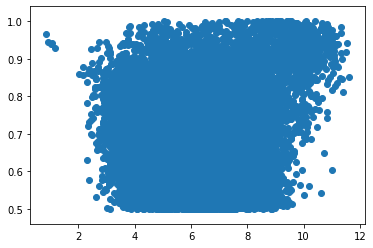

In [99]:
import matplotlib.pyplot as plt
plt.scatter(center_metric, opposing_metric)

In [100]:
# Apply criteria on amalgamation
high_conf = (predictions > (1 - rho)) | (predictions < rho)
high_agr = (center_metric > pi_1) & (opposing_metric > pi_2) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < rho) & high_agr

/zfsauton2/home/mdeartea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(array([2014., 3804., 4080., 4574., 4711., 3588., 2491., 1902., 2118.,
        7940.]),
 array([0.05754671, 0.14740044, 0.23725418, 0.32710791, 0.41696164,
        0.50681538, 0.59666911, 0.68652284, 0.77637658, 0.86623031,
        0.95608404]),
 <a list of 10 Patch objects>)

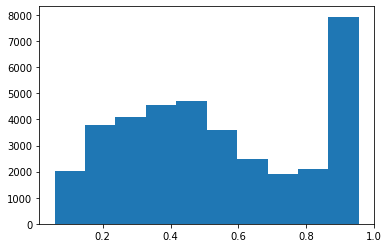

In [101]:
plt.hist(predictions)

In [102]:
print('high_conf:', sum(high_conf))
print('high_agr:', sum(high_agr))
print('high_agr_correct:', sum(high_agr_correct))

high_conf: 1367
high_agr: 729
high_agr_correct: 724


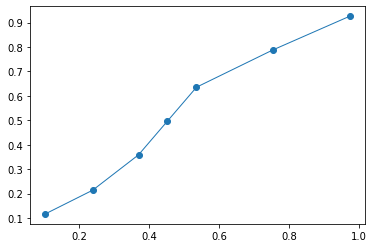

In [103]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(tar_train['D'], predictions, n_bins=7)
plt.plot(prob_true,prob_pred, marker='o', linewidth=1, label='logreg')


In [104]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1'].copy()
tar_train['Ya'][high_agr_correct] = (1 - tau) * tar_train['Y1'][high_agr_correct] \
                                    + tau * tar_train['D'][high_agr_correct]

In [105]:
sum(tar_train['D']!=tar_train['Y1'])

18236

In [106]:
sum(tar_train['Ya']!=tar_train['Y1'])

567

In [107]:
#index for selective labels
index_amalg = [i==1.0 for i in tar_train['D']] | high_agr_correct

##### 3. Updated model

In [108]:
#model with selective labels
model = BinaryMLP(**params)
model = model.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg])

Loss: 0.438: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [109]:
Y_pred_amalg_test = model.predict(cov_test)

In [110]:
# #model without selective labels
# model = BinaryMLP(**params)
# model = model.fit(cov_train, tar_train['Ya'], nur_train[index_amalg])

In [111]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.7774642594925761

In [112]:
# Yc performance
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.7354278022142705

In [113]:
roc_auc_score(tar_test['Y3'],model.predict(cov_test))

0.8364368935302873

In [114]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.6523768881531475

##### 4. Train on observed data

In [115]:
model = BinaryMLP(**params)
model = model.fit(cov_train[tar_train['D']==1], tar_train['Y1'][tar_train['D']==1], nur_train)

Loss: 0.415: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [116]:
Y_pred_obs_test = model.predict(cov_test)

In [117]:
# Naive performance
roc_auc_score(tar_test['Y1'], model.predict(cov_test))

0.7680792854171744

In [118]:
# Yc performance
roc_auc_score(tar_test['Y2'],model.predict(cov_test))

0.6672463724296768

In [119]:
roc_auc_score(tar_test['Y3'],model.predict(cov_test))

0.7230549063017151

In [120]:
roc_auc_score(tar_test['D'],model.predict(cov_test))

0.5912392898888282

#### Hybrid

In [121]:
high_agr.shape

(37222,)

In [122]:
# Y_pred_hybrid_test = np.copy(Y_pred_obs_test)
# Y_pred_hybrid_test[high_agr_test] = Y_pred_h_test[high_agr_test]

NameError: name 'high_agr_test' is not defined

## Precision/Accuracy

In [123]:
def eval_pred_outcome(Y_outcome_test, Y_pred_test, Y_h_test, p):
    Y_pred_test_scrin = Y_pred_test[Y_h_test==1]
    Y_outcome_test_scrin = Y_outcome_test[Y_h_test==1]
    #print(sum(Y_outcome_test_scrin))
    idx_25qrtl_pred = np.argsort(Y_pred_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_test_scrin)))]
    #baseline
    baseline = sum(Y_outcome_test_scrin)/len(Y_outcome_test_scrin)
    #print(idx_25qrtl_pred )
    #print(sum(Y_outcome_test_scrin[idx_25qrtl_pred]))
    #precision and recall in top p% highsest scored screen-in
    precision_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/len(idx_25qrtl_pred)
    recall_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/sum(Y_outcome_test)
    
    return baseline, precision_p, recall_p

In [124]:
print('Eval resp. Y_obs')
print('f_y', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_obs
f_y (0.12117576484703059, 0.28, 0.4492939666238768)
f_A (0.12117576484703059, 0.2752, 0.441591784338896)
f_h (0.12117576484703059, 0.188, 0.30166880616174585)


In [125]:
print('Eval resp. Y_serv')
print('f_y', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_serv
f_y (0.4231153769246151, 0.6048, 0.3572778827977316)
f_A (0.4231153769246151, 0.6592, 0.389413988657845)
f_h (0.4231153769246151, 0.7016, 0.41446124763705106)


In [126]:
print('Eval resp. Y_sub')
print('f_y', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_sub
f_y (0.4527094581083783, 0.708, 0.3909010600706714)
f_A (0.4527094581083783, 0.8528, 0.4708480565371025)
f_h (0.4527094581083783, 0.9912, 0.5472614840989399)


In [127]:
def eval_pred(Y_pred_test, tar_test, p):
    dic_k_Y_pred = {}
    
    base_ooh, precision_ooh, recall_ooh = eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    base_serv, precision_serv, recall_serv = eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    base_sub, precision_sub, recall_sub = eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    
    dic_k_Y_pred['ooh'] = {'base': float(base_ooh), 'precision': float(precision_ooh), 'recall': float(recall_ooh)}
    dic_k_Y_pred['sub'] = {'base': float(base_sub), 'precision': float(precision_sub), 'recall': float(recall_sub)}
    dic_k_Y_pred['serv'] = {'base': float(base_serv), 'precision': float(precision_serv), 'recall': float(recall_serv)}
    
    return dic_k_Y_pred
    

In [128]:
def eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, p):
    dic_eval = {}
    
    dic_k = {}
    dic_k['Y_pred_obs_test'] = eval_pred(Y_pred_obs_test, tar_test, p)
    dic_k['Y_pred_h_test'] = eval_pred(Y_pred_h_test, tar_test, p)
    #dic_k['Y_pred_hybrid_test'] = eval_pred(Y_pred_hybrid_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
    #print('done with Y_pred_hyb_test')
    dic_k['Y_pred_amalg_test'] = eval_pred(Y_pred_amalg_test, tar_test, p)

    
    dic_eval[0] = dic_k
    
    return dic_eval

In [129]:
list_dics =[]
for p in np.arange(0.05, 0.4, 0.05):
    list_dics.append(eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, p))

In [130]:
dic_25 = eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, 0.25)


In [131]:
def plot_perf_bar(dic_eval, models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(dic_eval.keys())
    
    n_labels = len(labels)
    
    fig, ax = plt.subplots(figsize=(10,5))
    index = np.arange(n_labels)
    bar_width = 0.15
    opacity = 0.8
    colors = ['green', 'darkred', 'yellow', 'blue']
    hatches = ['//', '-', '\\', '.']
    
    
    m_idx =0
    for m in models:
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            if metric == 'precision':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['precision']
            
            if metric == 'recall':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['recall']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list)  
            l_idx += 1
        rects = plt.bar(index+m_idx*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color=colors[m_idx], capsize=7,  width=.1, hatch = hatches[m_idx],
                            label=plot_labels[m_idx])        
            
            
        m_idx+=1                
    
    
    for n in index[:-1]:
        if metric=='precision':
            t= 0.8
        else:
            t=0.7
        plt.axvline(x=n+t, color='grey', linestyle='--')
        
    if metric=='precision':
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            for k in range(K):
                metric_list[k] = dic_eval[k][m][l]['base']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list) 
            l_idx +=1
        rects = plt.bar(index+len(models)*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color='grey',capsize=7,  width=.1,label='Overall prev.')     

    plt.ylabel(metric,fontsize=25)
    #plt.ylim((0,1.05))
    #plt.title('Performance of outcomes by model',fontsize=18)
    plt.xticks(index + 1.5*bar_width, ('OOH', 'Substantiated', 'Services'),fontsize=18)
    plt.yticks(fontsize=16)
    if legend_appear==True:
        plt.legend(loc = 'upper left', fontsize=18)
    plt.ylim(0.0,y_max)
    plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

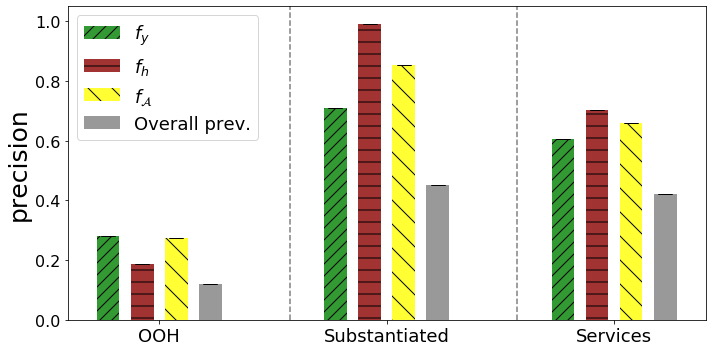

In [132]:
plot_perf_bar(dic_25, models = ['Y_pred_obs_test', 'Y_pred_h_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$',   '$f_\mathcal{A}$' ])

In [133]:
def plot_perf_bar(list_dics, index = np.arange(0.05, 0.4, 0.05), models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(list_dics[0].keys())
    
    n_groups = len(labels)
    
    fig, ax_list = plt.subplots(1,n_groups, figsize=(14,5))
    N=len(list_dics)
    
    bar_width = 0.1
    opacity = 0.8
    colors = ['green', 'darkred', 'goldenrod', 'blue']
    hatches = ['//', '-', '\\', '.']
    l_idx = 0
    for l in labels:
        m_idx =0
        for m in models:
            plot_mean = [0]*N
            plot_std = [0]*N

            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                if metric == 'precision':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['precision']

                if metric == 'recall':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['recall']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list)  
                dic_idx += 1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color=colors[m_idx], capsize=7, 
                               label=plot_labels[m_idx])        
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color=colors[m_idx], capsize=7)     

            m_idx+=1                
        

#         for n in index[:-1]:
#             if metric=='precision':
#                 t= (len(list_dics)-1)*bar_width+0.2
#             else:
#                 t= len(list_dics)*bar_width
#             plt.axvline(x=n+t, color='grey', linestyle='--')

        if metric=='precision':
            plot_mean = [0]*N
            plot_std = [0]*N
            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['base']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list) 
                dic_idx +=1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color='grey',capsize=7, label='base')     
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color='grey',capsize=7)     
        l_idx+=1
        
        
   # plt.ylabel(metric,fontsize=25)
    ax_list[0].set_ylabel(metric,fontsize=20)
    ax_list[1].set_xlabel('top p%',fontsize=20)
    
    for k in range(n_groups):
        ax_list[k].set_title(labels[k],fontsize=20)
    
    
    ax_list[2].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)
    
    #ax_list[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #  fancybox=True, shadow=True, ncol=5)
    
    #plt.xticks(index+dic_idx*bar_width)
    
#     plt.yticks(fontsize=16)
#     if legend_appear==True:
#         plt.legend(loc = 'upper left', fontsize=18)
    #plt.ylim(0.0,y_max)
    #plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

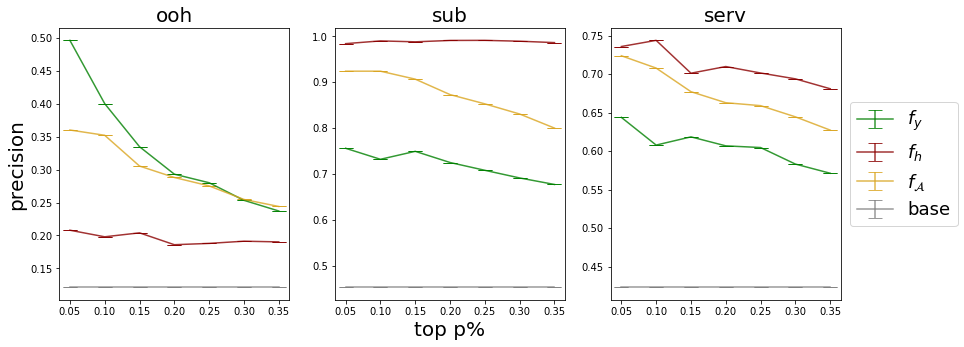

In [134]:
plot_perf_bar(list_dics, index = np.arange(0.05, 0.4, 0.05), models = ['Y_pred_obs_test', 'Y_pred_h_test','Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$',  '$f_\mathcal{A}$' ])